In [1]:
# Vehicle Detection
# This project aims to identify vehicles and non vehicles in a set of videos.
#Pipeline
# 1. Get the Images 
# Create color histogram and hog features
# Get the images and do sliding window operation and identify the vehicles/nonvehicles.
# Apply Heatmap and get the Boxes.
# 2. Get the Video and do as above.

#Resources
# https://discussions.udacity.com/t/good-tips-from-my-reviewer-for-this-vehicle-detection-project/232903

In [2]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
from skimage.feature import hog
from scipy.ndimage.measurements import label
import os
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split
%matplotlib inline

c:\users\anand\miniconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


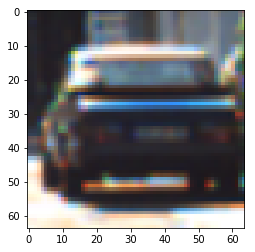

In [3]:
# read images and display
# read Videos
# Training Images to identify car and non car
image = mpimg.imread('./vehicles/KITTI_extracted/1.png')
plt.imshow(image)

8792
./vehicles/KITTI_extracted\2111.png
./vehicles/GTI_Far\image0421.png
./vehicles/GTI_Left\image0916.png
./vehicles/GTI_MiddleClose\image0492.png
./vehicles/GTI_Right\image0950.png
(64, 64, 3)


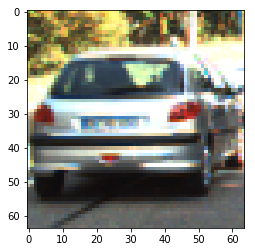

In [4]:
# Create a list of car images

images = glob.glob('./vehicles/KITTI_extracted/*.png') 

cars = []

for image in images:
    cars.append(image)
    
images = glob.glob('./vehicles/GTI_Far/*.png')

for image in images:
    cars.append(image)
    
images = glob.glob('./vehicles/GTI_Left/*.png')

for image in images:
    cars.append(image)
    
images = glob.glob('./vehicles/GTI_MiddleClose/*.png')

for image in images:
    cars.append(image)

images = glob.glob('./vehicles/GTI_Right/*.png')

for image in images:
    cars.append(image)
    
print(len(cars))
print(cars[1234])
print(cars[6300])
print(cars[7650])
print(cars[8125])
print(cars[8780])
image = mpimg.imread(cars[1234])
ncarshape = image.shape
print(ncarshape)
plt.imshow(image)
outfile = './output_images/car.jpg'
mpimg.imsave(outfile, image)

In [5]:
# Create a list of car images
ncimages = glob.glob('./non-vehicles/GTI/*.png')

notcars = []

for image in ncimages:
    notcars.append(image)

ncimages = glob.glob('./non-vehicles/Extras/*.png')    

for image in ncimages:
    notcars.append(image)

    

print(len(notcars))
print(notcars[5823])
print(notcars[123])
image = mpimg.imread(notcars[1234])
outfile = './output_images/notcar.jpg'
mpimg.imsave(outfile, image)

8968
./non-vehicles/Extras\extra3120.png
./non-vehicles/GTI\image1109.png


In [6]:
#Tuning Parameters
# We will define a set of Parameters to create the features
# performs under different binning scenarios
spatial = 16
histbin = 16

colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 8
hog_channel = 0 # Can be 0, 1, 2, or "ALL"

ystart = 420 # Change as per sampel images
ystop = 680 # change as per sample images
scale = 1

In [7]:

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    #return np.hstack((color1, color2, color3))
    return color1

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

In [8]:
def extract_features2(img, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256),orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
            # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        
    else: feature_image = np.copy(img)
    
    # Apply bin_spatial() to get spatial color features
    spatial_features = bin_spatial(feature_image, size=spatial_size)
    # Apply color_hist() also with a color space option now
    hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
    # Append the new feature vector to the features list
    # Call get_hog_features() with vis=False, feature_vec=True
    if hog_channel == 'ALL':
        hog_features = []
        hog_feat1 = get_hog_features(feature_image[:,:,0], orient, 
                                     pix_per_cell, cell_per_block, vis=False, feature_vec=True) 
        hog_feat2 = get_hog_features(feature_image[:,:,1], orient, 
                                     pix_per_cell, cell_per_block, vis=False, feature_vec=True) 
        hog_feat3 = get_hog_features(feature_image[:,:,2], orient, 
                                     pix_per_cell, cell_per_block, vis=False, feature_vec=True) 
        hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
    else:
        hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
    #features.append(hog_features)
    features.append(np.concatenate((spatial_features, hist_features, hog_features)))
    # Return list of feature vectors
    return features

In [9]:
def extract_features3(img, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256),orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    histo_features = []
    spat_features = []
    # Iterate through the list of images
            # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        
    else: feature_image = np.copy(img)
    
    # Apply bin_spatial() to get spatial color features
    spatial_features = bin_spatial(feature_image, size=spatial_size)
    # Apply color_hist() also with a color space option now
    hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
    # Append the new feature vector to the features list
    # Call get_hog_features() with vis=False, feature_vec=True
    if hog_channel == 'ALL':
        hog_features = []
        hog_feat1 = get_hog_features(feature_image[:,:,0], orient, 
                                     pix_per_cell, cell_per_block, vis=False, feature_vec=True) 
        hog_feat2 = get_hog_features(feature_image[:,:,1], orient, 
                                     pix_per_cell, cell_per_block, vis=False, feature_vec=True) 
        hog_feat3 = get_hog_features(feature_image[:,:,2], orient, 
                                     pix_per_cell, cell_per_block, vis=False, feature_vec=True) 
        hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))        
    else:
        hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
    features.append(hog_features)
    spat_features.append(spatial_features)
    histo_features.append(hist_features)
        #features.append(np.concatenate((spatial_features, hist_features, hog_features)))
    # Return list of feature vectors
    return features,spat_features,histo_features

c:\users\anand\miniconda3\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


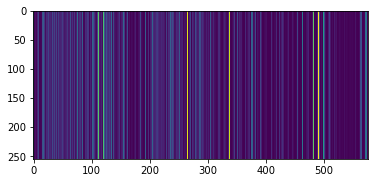

In [10]:


car_image = cv2.imread(cars[123])
notcar_image = cv2.imread(notcars[124])



t=time.time()
car_features, car_spat, car_hist = extract_features3(car_image, cspace=colorspace, spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range=(0, 256),orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features, noncar_spat, noncar_hist = extract_features3(notcar_image, cspace=colorspace, spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range=(0, 256), orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)




car_features = 255*car_features
notcar_features = 255*notcar_features
car_spat = 255*car_spat
car_hist = 255*car_hist
noncar_spat = 255*noncar_spat
noncar_hist = 255*noncar_spat

plt.imshow(car_features)
outfile = './output_images/car_features.jpg'
mpimg.imsave(outfile, car_features)
outfile2 = './output_images/car_spatial.jpg'
mpimg.imsave(outfile2, car_spat)
outfile3 = './output_images/car_hist.jpg'
mpimg.imsave(outfile3, car_hist)
outfile4 = './output_images/noncar_features.jpg'
mpimg.imsave(outfile4, notcar_features)
outfile5 = './output_images/noncar_spatial.jpg'
mpimg.imsave(outfile5, noncar_spat)
outfile6 = './output_images/noncar_hist.jpg'
mpimg.imsave(outfile6, noncar_hist)


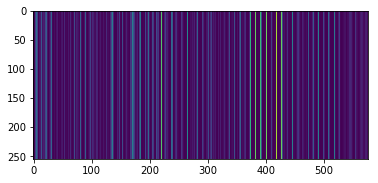

In [11]:
plt.imshow(notcar_features)
outfile = './output_images/notcar_features.jpg'
mpimg.imsave(outfile, notcar_features)

In [12]:



# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256),orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Append the new feature vector to the features list
                # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            hog_feat1 = get_hog_features(feature_image[:,:,0], orient, 
                                         pix_per_cell, cell_per_block, vis=False, feature_vec=True) 
            hog_feat2 = get_hog_features(feature_image[:,:,1], orient, 
                                         pix_per_cell, cell_per_block, vis=False, feature_vec=True) 
            hog_feat3 = get_hog_features(feature_image[:,:,2], orient, 
                                         pix_per_cell, cell_per_block, vis=False, feature_vec=True) 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        features.append(np.concatenate((spatial_features, hist_features, hog_features)))
    # Return list of feature vectors
    return features



# reduce sample size while testing offline
sample_size = 2000
cars = cars[0:sample_size]
notcars = notcars[0:sample_size]



t=time.time()
car_features = extract_features(cars, cspace=colorspace, spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range=(0, 256),orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features(notcars, cspace=colorspace, spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range=(0, 256), orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract BIN+HIST+HOG features...')
# Create an array stack of feature vectors



c:\users\anand\miniconda3\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


71.71 Seconds to extract BIN+HIST+HOG features...


In [13]:
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using spatial binning of:',spatial,
    'and', histbin,'histogram bins')

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC(C=1.0)
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Using spatial binning of: 16 and 16 histogram bins
Using: 9 orientations 8 pixels per cell and 8 cells per block
Feature vector length: 880
0.37 Seconds to train SVC...
Test Accuracy of SVC =  0.9712
My SVC predicts:  [ 0.  0.  1.  0.  0.  1.  0.  1.  1.  1.]
For these 10 labels:  [ 0.  0.  1.  0.  1.  1.  0.  1.  1.  1.]
0.002 Seconds to predict 10 labels with SVC


./test_images\test1.jpg


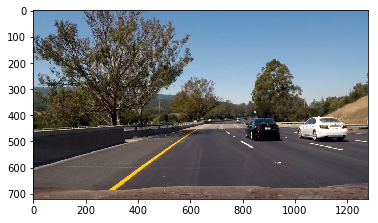

In [14]:
img_to_test = []
images = glob.glob('./test_images/*.jpg')
for image in images:
    img_to_test.append(image)

print(img_to_test[0])
img = mpimg.imread(img_to_test[5])
plt.imshow(img)

In [15]:
# Define a class to receive the characteristics of each line detection
class Box_list():
    def __init__(self):
        
        #  values of the last n fits of the line
        self.box = [] 

        

In [16]:
current = Box_list()
previous = Box_list()
Previous2 = Box_list()
previous3 = Box_list()
previous4 = Box_list()
previous5 = Box_list()

In [17]:



# Define a single function that can extract features using hog sub-sampling and make predictions


def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
              cell_per_block, spatial, histbin, hog_channel, hist_range=(0, 256), cspace=colorspace):
    
    draw_img = np.copy(img)
    box_list = []
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
   #img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    #ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    imshape = img_tosearch.shape
    ctrans_tosearch = cv2.resize(img_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    # Compute individual features for the entire image
    block_features = extract_features2(ctrans_tosearch, cspace=colorspace, spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range=(0, 256),orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
    
    # Define blocks and steps as above
    nxblocks = (ctrans_tosearch.shape[1] // pix_per_cell)-1
    nyblocks = (ctrans_tosearch.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    for window in range(64,256,32):
        #window = 80
        
        nblocks_per_window = (window // pix_per_cell)-1 
        cells_per_step = 2  # Instead of overlap, define how many cells to step
        nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
        nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    

    
        for xb in range(nxsteps):
            for yb in range(nysteps):
                ypos = yb*cells_per_step
                xpos = xb*cells_per_step
                xleft = xpos*pix_per_cell
                ytop = ypos*pix_per_cell

                # Extract the image patch
                subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
                test_features = extract_features2(subimg, cspace=colorspace, spatial_size=(spatial, spatial),
                                                  hist_bins=histbin, hist_range=(0,256),orient=orient, 
                                                  pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                                  hog_channel=hog_channel)
          
   
                test_prediction = svc.predict(test_features)
            
                bbox =np.zeros((2,2), dtype = int)
           
       
                if test_prediction == 1:
                    xbox_left = np.int(xleft*scale)
                    ytop_draw = np.int(ytop*scale)
                    win_draw = np.int(window*scale)
                    # Bypassing this code
                    #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                    #bbox00 = xbox_left
                    #bbox01 = ytop_draw+ystart
                    #bbox10 = xbox_left+win_draw
                    #bbox11 = ytop_draw+win_draw+ystart
                    #bbox = ((bbox00, bbox01),(bbox10,bbox11))
                    #box_list.append(bbox)
                    box = ((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)) 
                    box_list.append(box)
                    cv2.rectangle(draw_img,box[0],box[1],(0,0,255),6) 
                    heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return draw_img, box_list, heatmap




def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        current.box.append(bbox)
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img



In [18]:
#Heat Map to remove false


# Read in image similar to one shown above 
image = img
heat = np.zeros_like(image[:,:,0]).astype(np.float)



for i in range(0,6):
    img = mpimg.imread(img_to_test[i])
    outfile = './output_images/bbox' + str(i) + '.jpg'
    outfile2 = './output_images/heatmap' + str(i) + '.jpg'
    outfile3 = './output_images/carbox' + str(i) + '.jpg'
    
    out_img, box_list, heatmap = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                          cell_per_block, spatial, histbin, hog_channel,  hist_range=(0, 256), cspace=colorspace)
    
    
    mpimg.imsave(outfile, out_img)
    
    # Add heat to each box in box list
    #heat = add_heat(heat,box_list)
    
    # Apply threshold to help remove false positives
    heatmap = apply_threshold(heatmap,1)
 
            
    heatmap = np.clip(heatmap, 0, 255)


    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
   
    
    mpimg.imsave(outfile2, heatmap)
    mpimg.imsave(outfile3, draw_img)
    


c:\users\anand\miniconda3\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [19]:
# Video Pipeline
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import collections
heatmaps = collections.deque(maxlen=10)
global Frame
indx = 0

In [20]:
def process_image(image, Frame=0):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    global indx
    v_avg_hmapimgs = glob.glob('./output_imges/V_avg_heatmap*.jpg')
    Frame = len(v_avg_hmapimgs)+1
    out_img, box_list, heatmap = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                          cell_per_block, spatial, histbin, hog_channel,  hist_range=(0,256), cspace=colorspace)
    
    #heat = np.zeros_like(image[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    #heat = add_heat(heat,box_list)
    
    # Apply threshold to help remove false positives
    heatmaps.append(heatmap)
    avg_heatmap = sum(heatmaps)
    avg_heatmap = apply_threshold(avg_heatmap,5)

    # Visualize the heatmap when displaying    
    avg_heatmap = np.clip(avg_heatmap, 0, 2550)


    # Find final boxes from heatmap using label function
    labels = label(avg_heatmap)
    final = draw_labeled_bboxes(np.copy(image), labels)
    outfile1 = './output_images/V_avg_heatmap' + str(indx) + '.jpg'
    outfile2 = './output_images/V_heatmap' + str(indx) + '.jpg'
    outfile3 = './output_images/V_carbox' + str(indx) + '.jpg'
    mpimg.imsave(outfile1, avg_heatmap)
    mpimg.imsave(outfile2, heatmap)
    mpimg.imsave(outfile3, final)
    indx +=1
    
    return final

In [21]:
white_output = 'white.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|███████████████████████████████████▉| 1260/1261 [2:12:33<00:06,  6.24s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

Wall time: 2h 12min 37s


In [27]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))